### Part 1:  Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. You can view it at `examples/1D-SLAM.ipynb`. Your first task is to code this from scratch.

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct it is using `jax`'s `jacobian`. Its usage is explained in the supplementary notebook (`examples/`).

### How to get started?

1. Go through the example and understand the optimization procedure.
2. Generate the data as in the example.
3. Write the derivatives of the function with respect to the constraints
4. Create the final jacobian and write the update steps using Gauss Newton

This tiny example will help make sense of the next question, as it's largely just an extension of this.

Finally, plot the loop closure constraint, poses, and error at every iteration as well. Since this is a one dimensional example, you can just assume x = y.

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

In [25]:
odom_data = jnp.array([1.1, 1.0, 1.1, -2.7, 0]) # odometry data
odom_states = jnp.array([0, 1.1, 2.1, 3.2, 0.5]) # pose of the robot at each time step according to the odometry data

weights = jnp.array([100, 100, 100, 100, 100, 1000])
info_matrix = jnp.diag(weights)

def update_pose(curr_pose, odometer_reading):
    return curr_pose + odometer_reading

def compute_residual(current_pose, odometer_readings):
    residuals = []
    for i in range(odometer_readings.shape[0]):
        if i == odometer_readings.shape[0] - 1:
            residuals.append(update_pose(current_pose[0], odometer_readings[i]) - current_pose[i]) 
        else:
            residuals.append(update_pose(current_pose[i], odometer_readings[i]) - current_pose[i + 1])
    residuals.append(current_pose[0]) 
    return jnp.asarray(residuals)

iterations = 5
errors = []
poses = [] 

for i in range(iterations):
    poses.append(odom_states.copy())
    jax_jacob = jax.jacfwd(compute_residual)
    jacobian = jax_jacob(odom_states, odom_data)
    H = jacobian.T @ info_matrix @ jacobian
    b = jacobian.T @ info_matrix @ compute_residual(odom_states, odom_data)
    delta_x = jnp.linalg.inv(H) @ -b
    curr_residual = compute_residual(odom_states, odom_data)
    err = 0.5 * curr_residual.T @ info_matrix @ curr_residual
    errors.append(err)
    print("For Iteration " + str(i+1))
    print("error is: " + str(err))
    print("delta_x is: " + str(delta_x))
    print("*****")
    odom_states = odom_states + delta_x

For Iteration 1
error is: 12.5
delta_x is: [-1.6298145e-09 -9.9999979e-02 -1.9999993e-01 -3.0000010e-01
 -4.0000007e-01]
*****
For Iteration 2
error is: 2.5
delta_x is: [1.2721917e-09 1.8676763e-08 4.0849716e-08 1.8700028e-07 6.4929957e-08]
*****
For Iteration 3
error is: 2.5
delta_x is: [ 2.9795461e-11  1.7493953e-08  3.9726469e-08 -5.2481898e-08
 -3.1292484e-09]
*****
For Iteration 4
error is: 2.5
delta_x is: [-2.6020852e-16  1.7464153e-08  3.9696683e-08 -5.2511698e-08
 -3.1590415e-09]
*****
For Iteration 5
error is: 2.5
delta_x is: [-2.6020852e-16  1.7464153e-08  3.9696683e-08 -5.2511698e-08
 -3.1590415e-09]
*****


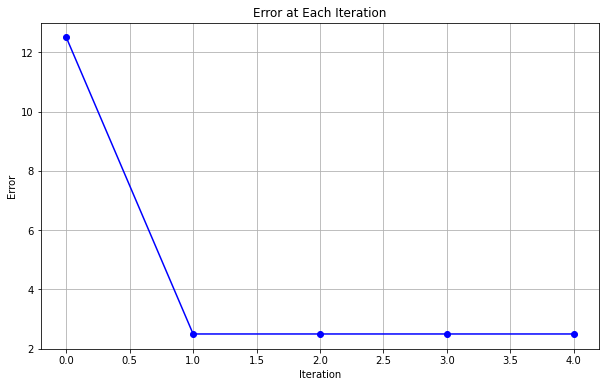

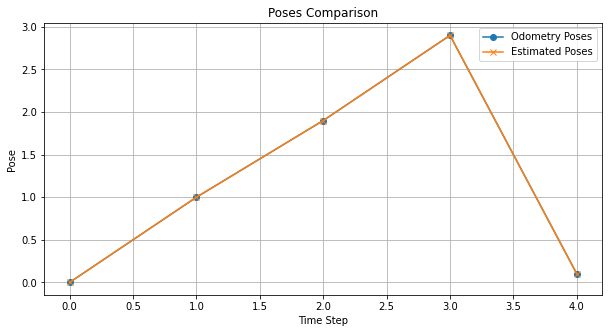

In [32]:
# Plot the loop closure constraint
plt.figure(figsize=(10, 6))
plt.plot(range(iterations), errors, marker='o', linestyle='-', color='b')
plt.title('Error at Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.grid(True)
plt.show()

# Plot poses
plt.figure(figsize=(10, 5))
plt.plot(odom_states, label='Odometry Poses', marker='o')
plt.plot(poses[-1], label='Estimated Poses', marker='x')
plt.xlabel('Time Step')
plt.ylabel('Pose')
plt.title('Poses Comparison')
plt.legend()
plt.grid(True)
plt.show()